<a href="https://colab.research.google.com/github/rubychen8407/brain-tumor-semantic-segmentation/blob/main/Tumor_Seg_unet(relu)_balenced(ok).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Fri Apr 23 17:08:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **save picture**

In [ ]:
import os

PROJECT_ROOT_DIR = "/content/drive/MyDrive/Colab Notebooks/HW2_Segmentation_MRI_project"

def save_fig(image_name,tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(PROJECT_ROOT_DIR, "image",image_name + "." + fig_extension)

  if tight_layout:
        plt.tight_layout()
  return plt.savefig(path, format=fig_extension, dpi=resolution)

# Download package

In [ ]:
!git clone https://github.com/samson6460/tf2_Segmentation.git

fatal: destination path 'tf2_Segmentation' already exists and is not an empty directory.


# Load datasets

In [ ]:
from tf2_Segmentation.utils import Segdata_reader
from tf2_Segmentation.utils import vis_img_mask

In [ ]:
!pip install imgaug==0.4.0

In [ ]:
import imgaug

imgaug.__version__

'0.4.0'

In [ ]:
import imgaug.augmenters as iaa

augmenter = iaa.Sequential([
    #iaa.Dropout([0.05, 0.2]),      # drop 5% or 20% of all pixels
    #iaa.Sharpen((0.0, 1.0)),       # sharpen the image
    iaa.Affine(rotate=(-45, 45)),   # rotate by -45 to 45 degrees
    #iaa.ElasticTransformation(alpha=50, sigma=5),  # apply water effect
    iaa.Fliplr(0.5),
    iaa.Crop(px=(0, 100)),
    #iaa.Crop(percent=(0, 0.3)),
    iaa.Flipud(0.5),
    ], 
    random_order=True)

In [ ]:
train_sreader = Segdata_reader(
    rescale=1/255,
    augmenter=augmenter,
    aug_times=5)
train_seq = train_sreader.imglayer_to_sequence(
    "/content/drive/Shareddrives/深度學習於生醫資料分析_1092/Datasets/Brain_Tumour_Segmentation/Train/img",
    "/content/drive/Shareddrives/深度學習於生醫資料分析_1092/Datasets/Brain_Tumour_Segmentation/Train/label",
    batch_size=5,
    class_colors=["w"],
    size=(416, 416))

In [ ]:
valid_sreader = Segdata_reader(rescale=1/255)
valid_seq = valid_sreader.imglayer_to_sequence(
    "/content/drive/Shareddrives/深度學習於生醫資料分析_1092/Datasets/Brain_Tumour_Segmentation/Valid/img",
    "/content/drive/Shareddrives/深度學習於生醫資料分析_1092/Datasets/Brain_Tumour_Segmentation/Valid/label",
    batch_size=5,
    class_colors=["w"],
    size=(416, 416))

In [ ]:
train_seq_data, train_seq_label = train_seq[0]

#for i in range(len(train_seq_data)):
 #   vis_img_mask(train_seq_data[i], train_seq_label[i])

# **U-net(relu)**

In [ ]:
from tf2_Segmentation.models import unet

In [ ]:
# pretrained_weights = "/content/drive/MyDrive/YM/UNET/weights/brain_tumor_416.h5"
# pretrained_weights = "/content/drive/MyDrive/YM/UNET/weights/brain_tumor_416_ce.h5"

model = unet(
    input_shape=(416, 416, 3),
    activation='relu',
    categorical_num=1,
    # pretrained_weights=pretrained_weights
    )

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 416, 416, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

# Compile the model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tf2_Segmentation.losses import dice_loss_func
from tf2_Segmentation.losses import balanced_categorical_crossentropy
from tf2_Segmentation.utils import get_class_weight
from tf2_Segmentation.metrics import dice_coef_func

In [ ]:
class_weight = get_class_weight(train_seq_label,method='effective')
print(class_weight) #mask跟沒有mask的比例

[1.94873149 0.05126851]


In [ ]:
model.compile(
    optimizer=Adam(lr=1e-5),
    loss=balanced_categorical_crossentropy(
        class_weight=class_weight),
    metrics=[dice_coef_func()])

In [ ]:
"""model.compile(
    optimizer=Adam(lr=1e-5),
    loss=dice_loss_func(smooth=1),
    metrics=["accuracy"])"""

'model.compile(\n    optimizer=Adam(lr=1e-5),\n    loss=dice_loss_func(smooth=1),\n    metrics=["accuracy"])'

## Train from sequence

In [ ]:
history = model.fit(
    train_seq,
    epochs=10,
    validation_data=valid_seq)

Epoch 1/10
1280/1280 [==============================] - 1195s 901ms/step - loss: 0.0335 - dice_coef: 0.6286 - val_loss: 0.0270 - val_dice_coef: 0.7940
Epoch 2/10
1280/1280 [==============================] - 664s 519ms/step - loss: 0.0169 - dice_coef: 0.7766 - val_loss: 0.0240 - val_dice_coef: 0.8471
Epoch 3/10
1280/1280 [==============================] - 666s 520ms/step - loss: 0.0143 - dice_coef: 0.8101 - val_loss: 0.0223 - val_dice_coef: 0.8708
Epoch 4/10
1280/1280 [==============================] - 666s 520ms/step - loss: 0.0121 - dice_coef: 0.8381 - val_loss: 0.0187 - val_dice_coef: 0.9030
Epoch 5/10
1280/1280 [==============================] - 666s 520ms/step - loss: 0.0105 - dice_coef: 0.8598 - val_loss: 0.0197 - val_dice_coef: 0.9284
Epoch 6/10
1280/1280 [==============================] - 666s 520ms/step - loss: 0.0088 - dice_coef: 0.8789 - val_loss: 0.0255 - val_dice_coef: 0.9085
Epoch 7/10
1280/1280 [==============================] - 666s 520ms/step - loss: 0.0084 - dice_coef:

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/HW2_Segmentation_MRI_project/model/unet_aug_relu_balenced/weights.h5")

# **save model**

In [ ]:
import os

def model_savebymodel(model_name, style="h5"):
  model_name=list("deeplabv3_aug","unet_relu_aug","unet_selu_aug")
  model_root_dir = "/content/drive/MyDrive/Colab Notebooks/HW2_Segmentation_MRI_project/model/"
  return model.save(os.path.join(model_root_dir, model_name, "weights." + style))

In [ ]:
"""weight_path=model_savebymodel(model_name="deeplabv3_aug")"""

'weight_path=model_savebymodel(model_name="deeplabv3_aug")'

## **trainig history**

In [ ]:
print(history)

In [ ]:
history.history.keys()

dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef'])

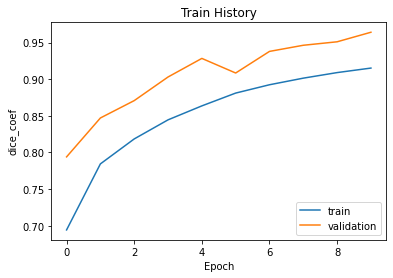

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Train History')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('train_History_dice_coef.png')

plt.show()

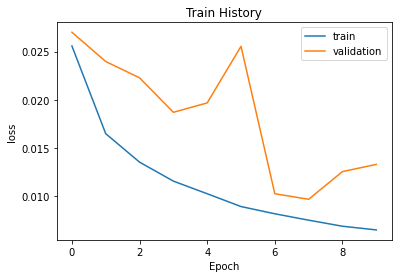

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train History')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('train_History_loss.png')

plt.show()

# **Draw the training processing plot**

In [ ]:
from tf2_Segmentation.utils import plot_history

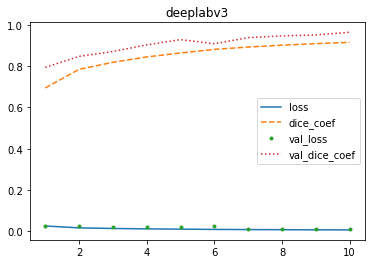

In [ ]:
accuracy_history = plot_history(history_dict=history.history, keys=('loss', 'dice_coef', 'val_loss', 'val_dice_coef'), xyLabel=[('epoch', 'dice_coef')], title="deeplabv3",  size=(6,4))

#https://github.com/samson6460/tf2_Segmentation/blob/master/utils/tools.py"""

In [ ]:
save_fig("deeplabv3")

<Figure size 432x288 with 0 Axes>

# Test

In [ ]:
from keras.models import load_model

In [ ]:
#?load_model

In [ ]:
#model = load_model(weight_path, custom_objects = {"dice_loss_func":dice_loss_func}, compile=False)

In [ ]:
from tf2_Segmentation.models import model_predict

In [ ]:
test_sreader = Segdata_reader(rescale=1/255)
test_data, test_label = test_sreader.imglayer_to_dataset(
    "/content/drive/Shareddrives/深度學習於生醫資料分析_1092/Datasets/Brain_Tumour_Segmentation/Test/img",
    "/content/drive/Shareddrives/深度學習於生醫資料分析_1092/Datasets/Brain_Tumour_Segmentation/Test/label",
    class_colors=["w"],
    size=(416, 416),
    thread_num=1000)

In [ ]:
prediction = model_predict(
    model, test_data,
    batch_size=3,
    verbose=1)

54/54 [==============================] - 11s 126ms/step


groundtruth:


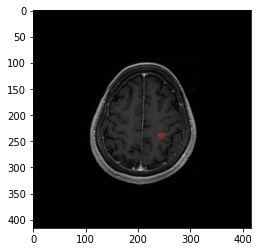

prediction:


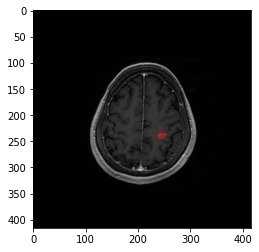

groundtruth:


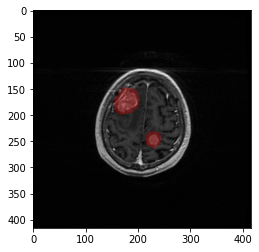

prediction:


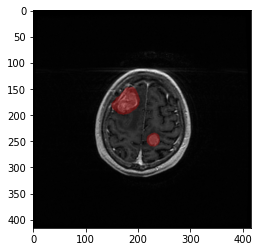

groundtruth:


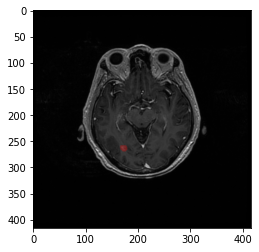

prediction:


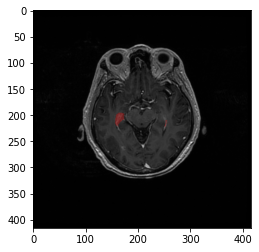

groundtruth:


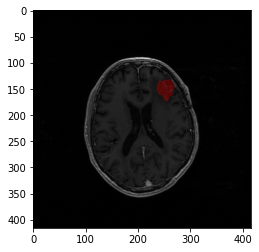

prediction:


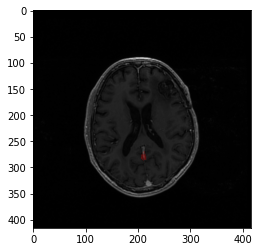

groundtruth:


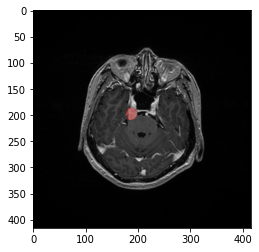

prediction:


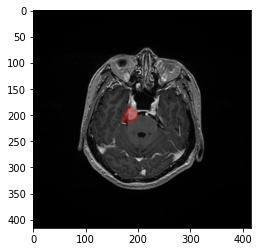

groundtruth:


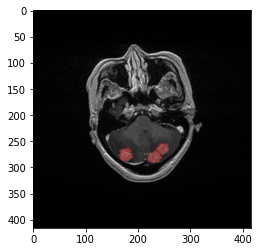

prediction:


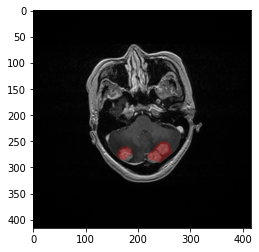

groundtruth:


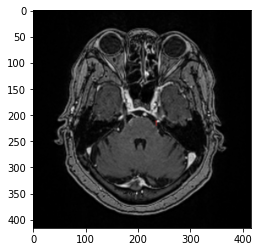

prediction:


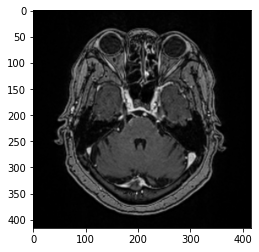

groundtruth:


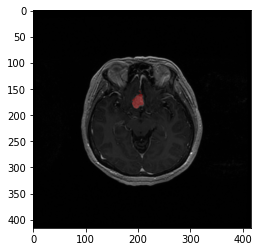

prediction:


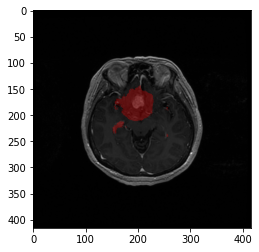

groundtruth:


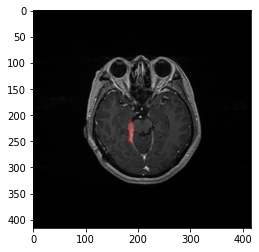

prediction:


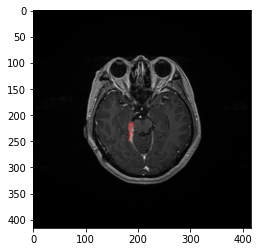

groundtruth:


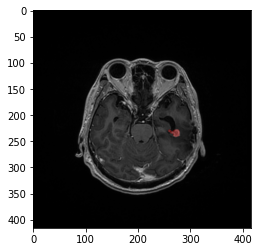

prediction:


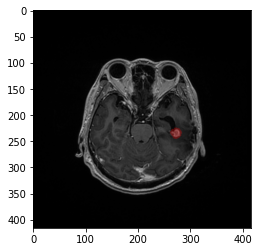

groundtruth:


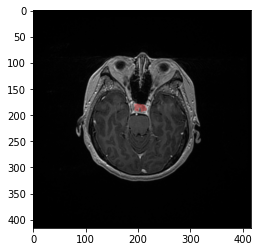

prediction:


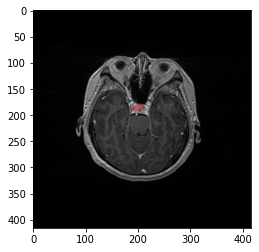

groundtruth:


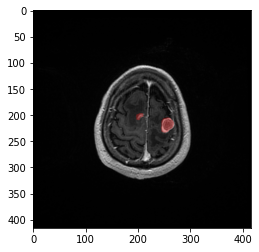

prediction:


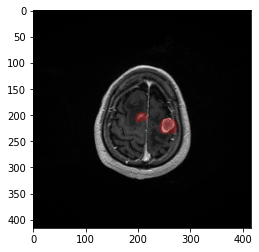

groundtruth:


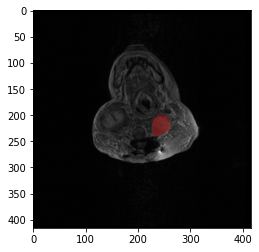

prediction:


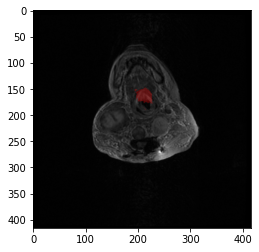

groundtruth:


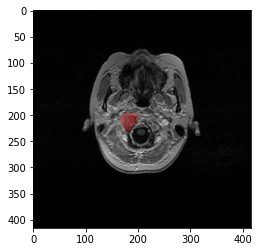

prediction:


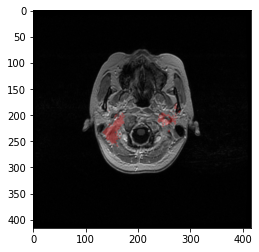

groundtruth:


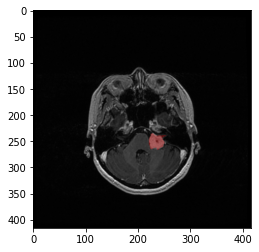

prediction:


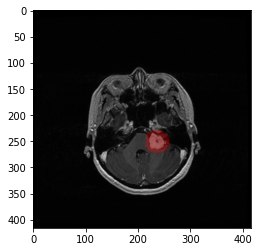

groundtruth:


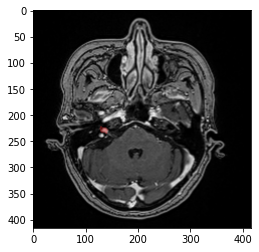

prediction:


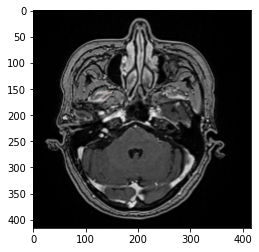

groundtruth:


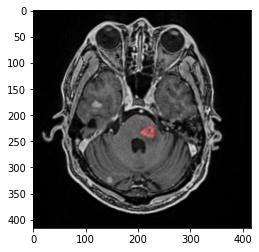

prediction:


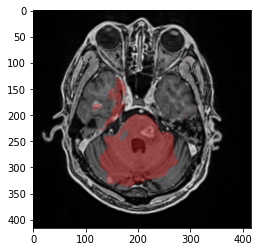

groundtruth:


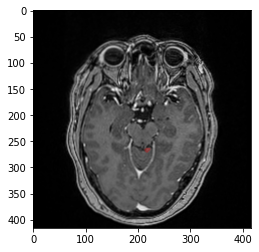

prediction:


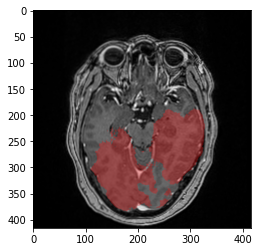

groundtruth:


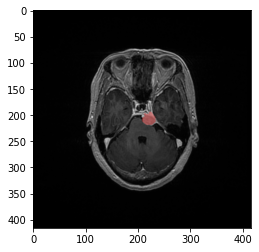

prediction:


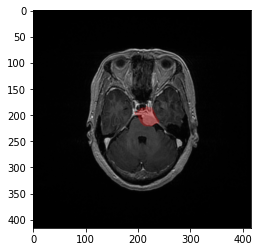

groundtruth:


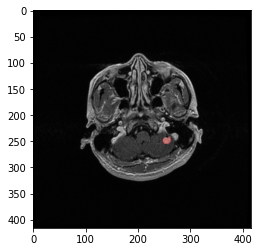

prediction:


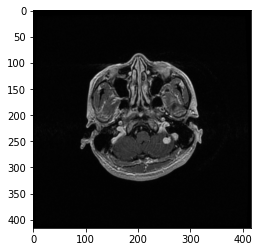

In [ ]:
for i in range(20):
    print("groundtruth:")
    vis_img_mask(test_data[i], test_label[i])
    print("prediction:")
    vis_img_mask(test_data[i], prediction[i])
    print("==================================")

# Show measurement

In [ ]:
from tf2_Segmentation.utils import get_dice
from tf2_Segmentation.utils import create_confusion_mat
from tf2_Segmentation.utils import create_score_mat, get_iou, get_jaccard
from tf2_Segmentation.metrics import be_binary_accuracy, dice_coef_func

In [ ]:
#get_iou(test_label, prediction, class_names=["tumor"], classifi_mode='one')

In [ ]:
get_dice(test_label, prediction, class_names=["tumor"])

tumor    0.198757
dtype: float64

In [ ]:
confusion_mat = create_confusion_mat(
    test_label, prediction,
    class_names=["tumor"])

confusion_mat

prediction,tumor,nothing
groundtruth,,
tumor,77388,41458
nothing,582485,26987629


In [ ]:
create_score_mat(confusion_mat)

,precision,recall,specificity,F1-score
tumor,0.117277,0.651162,0.978873,0.198757
nothing,0.998466,0.978873,0.651162,0.988572


In [ ]:
#get_jaccard(test_label, prediction, class_names=["tumor"], classifi_mode='one')

In [ ]:
be_binary_accuracy(test_label, prediction)

<tf.Tensor: shape=(160, 416, 416), dtype=float32, numpy=
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1